# Read IVUS images

In [1]:
#libraries
import SimpleITK as sitk
import glob
import os
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import numpy as np
import math
from math import sqrt
#from tqdm import tqdm

import pickle
import pandas as pd
import time
import os
#from feature_utils import *

#functions
def im2arr(x):
    return sitk.GetArrayFromImage(sitk.ReadImage(x))

#read in files
datadir= "data"
files = sorted(glob.glob(datadir+"/*.mha"))
im = im2arr(files[0])  #im becomes a numpy array
im.shape

(3970, 256, 256)

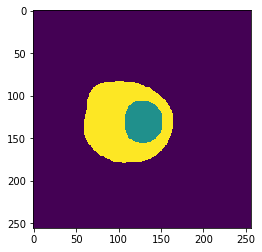

In [3]:
plt.imshow(im[2380])

In [4]:
def sample_stack(stack, rows=5, cols=5, start_with=10, show_every=3):
    fig,ax = plt.subplots(rows,cols,figsize=[12,12])
    for i in range(rows*cols):
        ind = start_with + i*show_every
        ax[int(i/rows),int(i % rows)].set_title('slice %d' % ind)
        ax[int(i/rows),int(i % rows)].imshow(stack[ind])
        ax[int(i/rows),int(i % rows)].axis('off')
    plt.show()

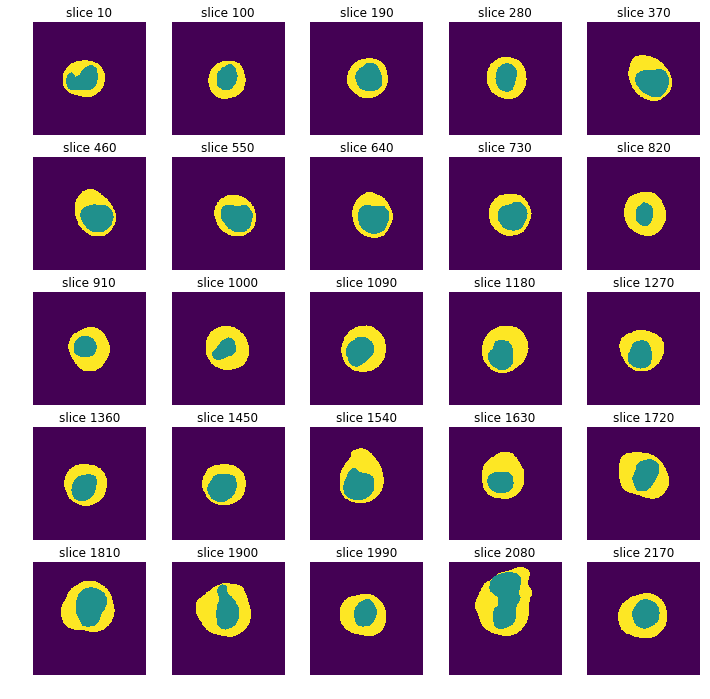

In [5]:
imstack = im2arr(files[0])
sample_stack(imstack, show_every=90)

# Ecentricity

In [6]:
im.shape

(3970, 256, 256)

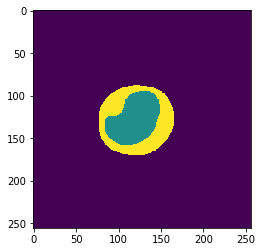

In [25]:
frame = im[0]
plt.imshow(frame)

In [26]:
unique, counts = np.unique(frame, return_counts=True)
>>> dict(zip(unique, counts))

{0: 59682, 1: 2829, 2: 3025}

In [41]:
np.unique(frame)

array([0, 1, 2], dtype=uint16)

In [27]:
frame8 = cv2.convertScaleAbs(frame,alpha=(255.0/2.0))
ret, thresh = cv2.threshold(frame8, 129, 255, 0)
frame8.dtype

dtype('uint8')

In [34]:
frame8

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [28]:
framergb = cv2.cvtColor(frame8,cv2.COLOR_GRAY2RGB)
#frame8rgb = cv2.convertScaleAbs(framergb)


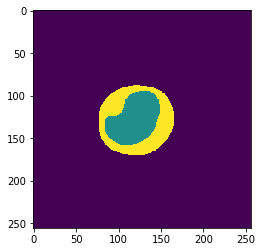

In [29]:
plt.imshow(frame8)

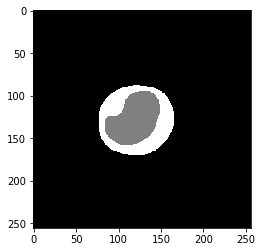

In [12]:
plt.imshow(framergb)

In [14]:
_, contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)

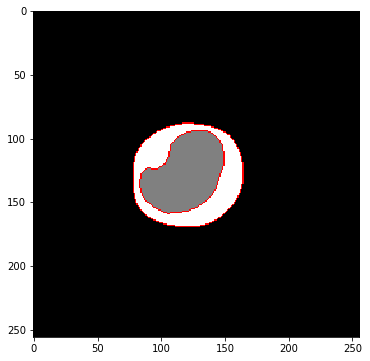

In [15]:
im2 = framergb.copy()
cv2.drawContours(im2, contours, -1, (255,0,0), 1)
plt.figure(figsize=[6,6])
plt.imshow(im2)

In [16]:
parent = [ x[-1] for x in hierarchy[0] ]
index = np.where(np.array(parent) == 0)[0][0]
lumen_c = contours[index]

In [17]:
M = cv2.moments(lumen_c)
cX = int(M["m10"] / M["m00"])
cY = int(M["m01"] / M["m00"])

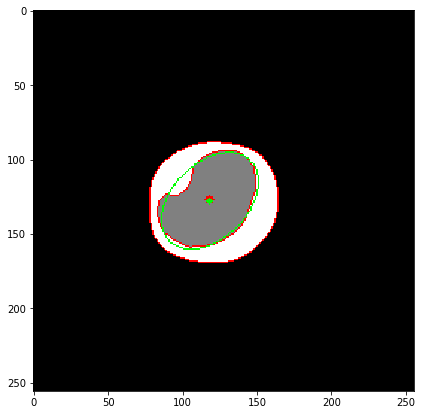

In [18]:
im3 = im2.copy()
cv2.drawContours(im3, lumen_c, -1, (255,0,0), 1)
cv2.circle(im3, (cX, cY), 3, (255,0,0), -1)
(x, y), (minaxis, maxaxis), angle = cv2.fitEllipse(lumen_c)
ellipse = cv2.fitEllipse(lumen_c)
cv2.ellipse(im3,ellipse,(0,255,0),1)
cv2.circle(im3, (round(x),round(y)), 2, (0,255,0), -1)
plt.figure(figsize=[7,7])
plt.imshow(im3)

In [19]:
print(minaxis,maxaxis)

50.585662841796875 76.45760345458984


# Lumen Diameter

/Users/paulnguyen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


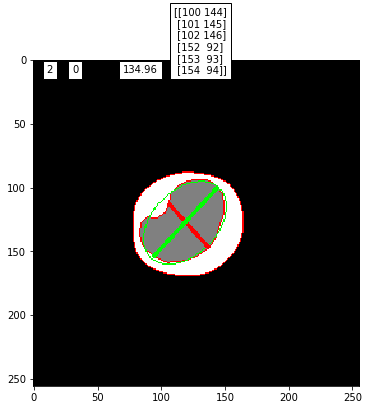

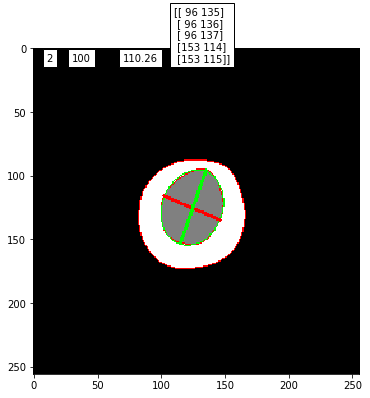

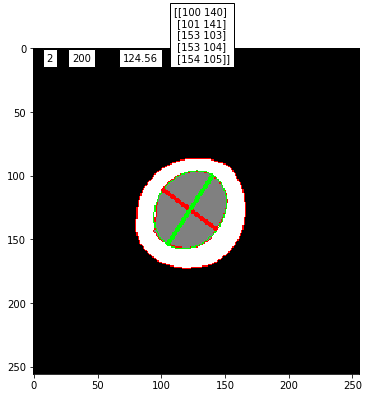

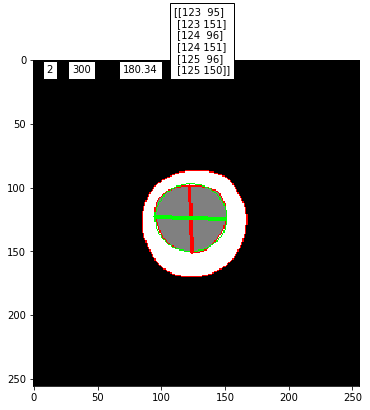

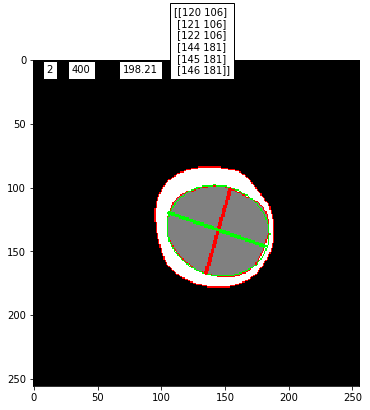

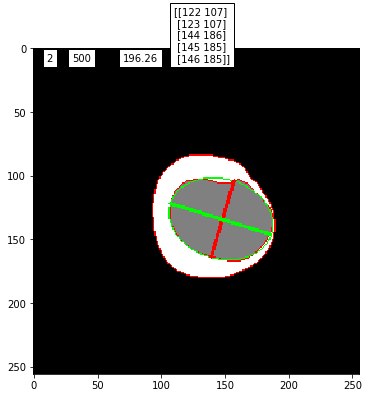

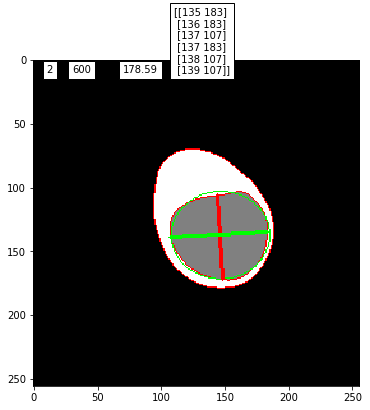

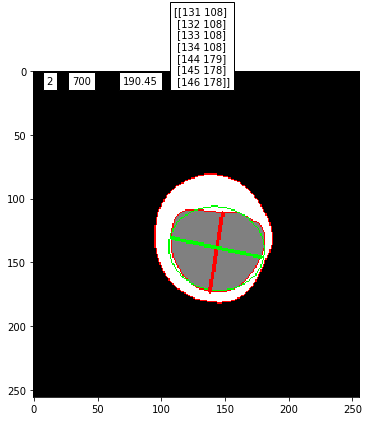

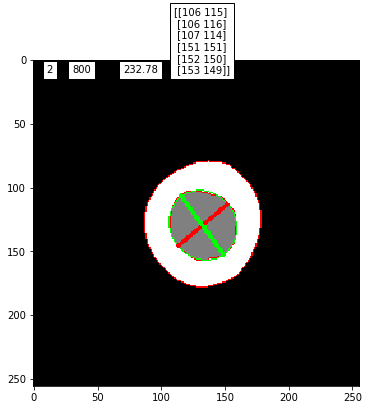

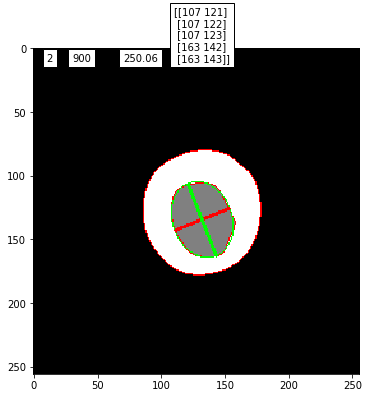

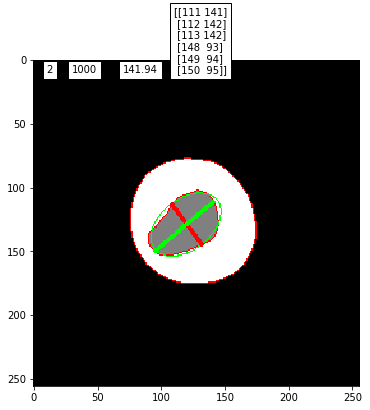

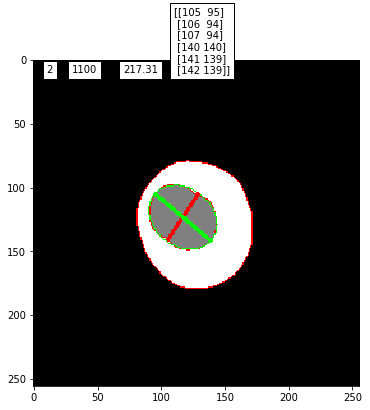

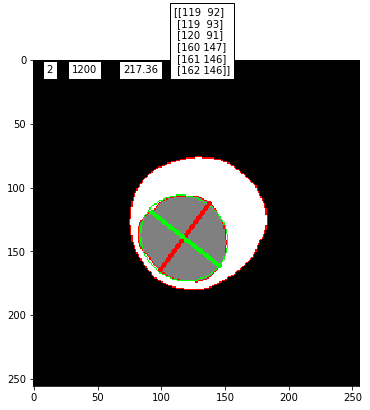

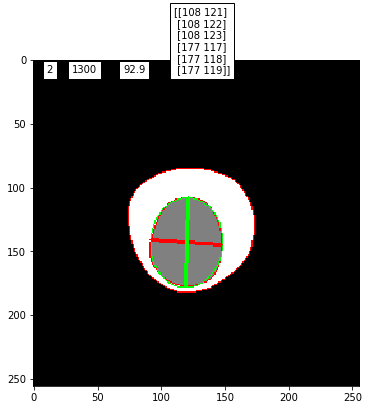

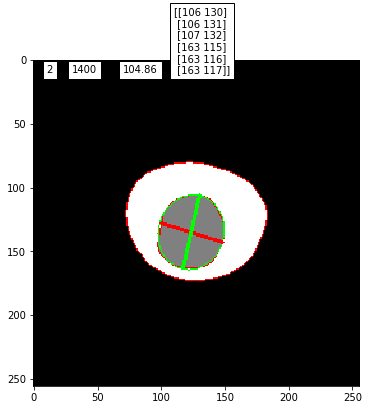

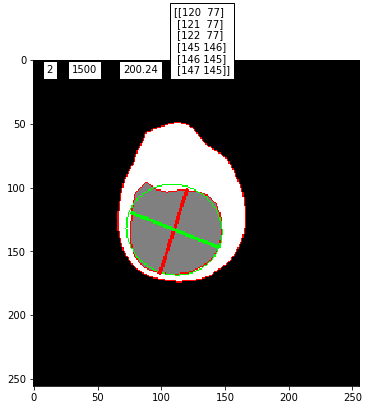

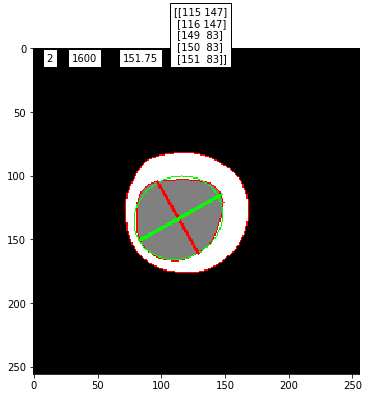

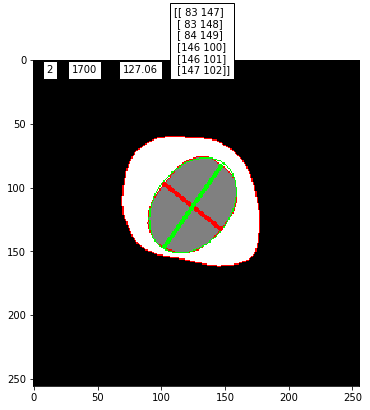

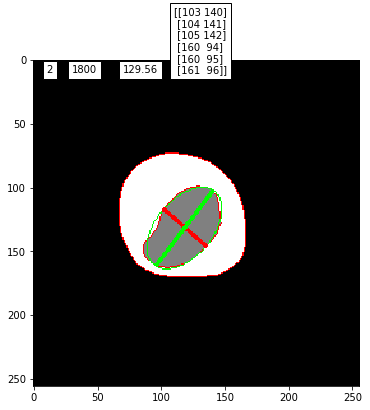

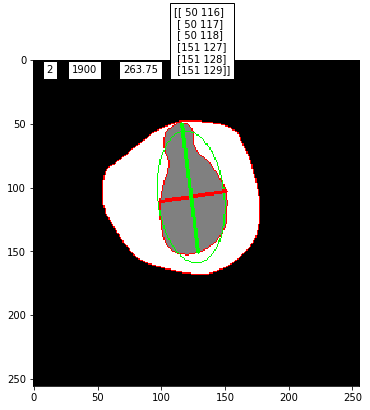

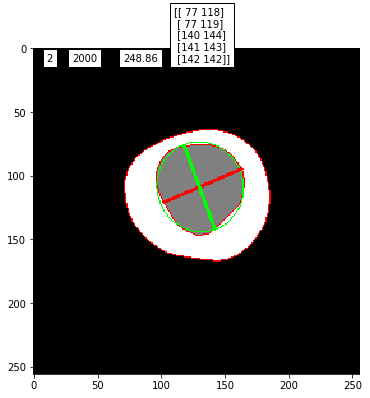

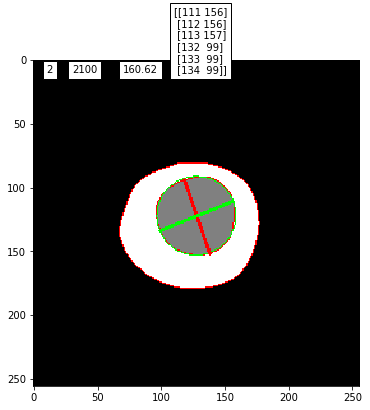

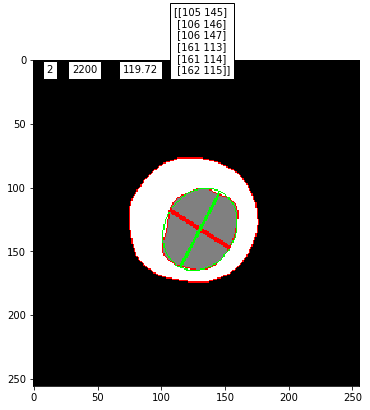

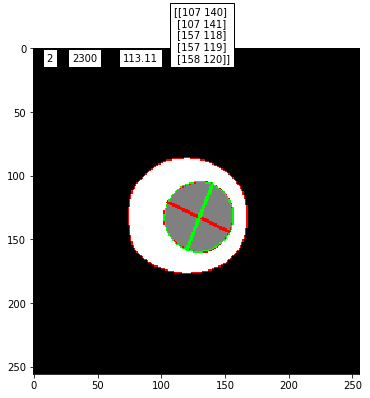

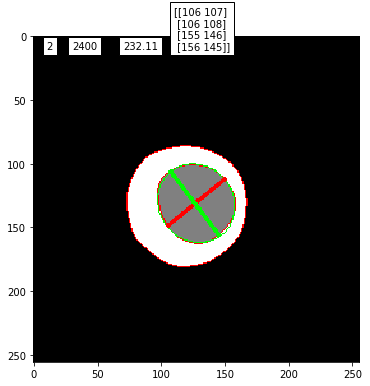

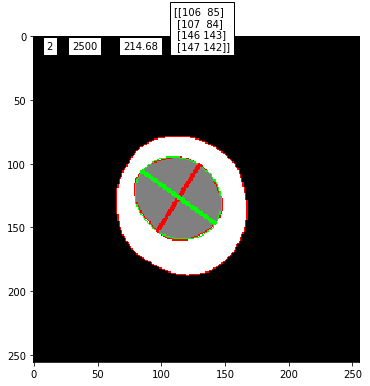

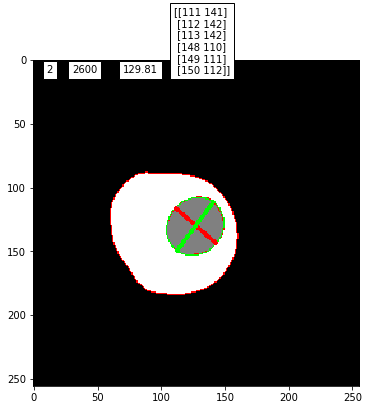

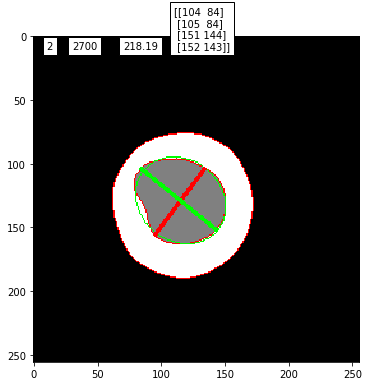

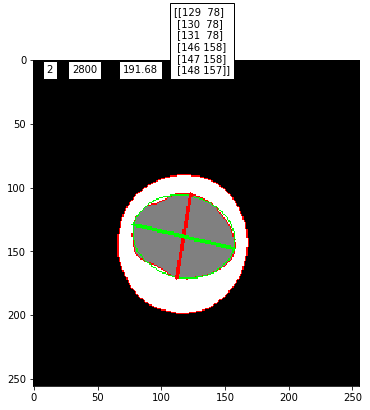

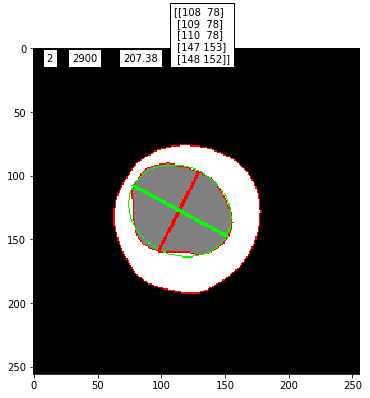

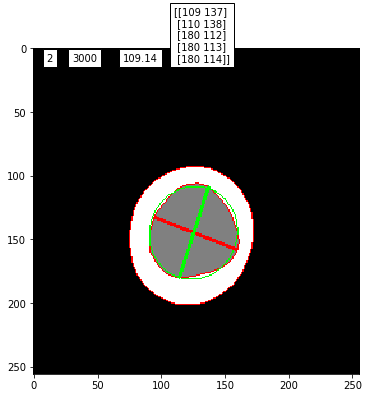

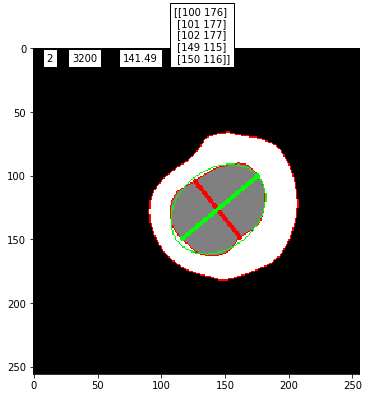

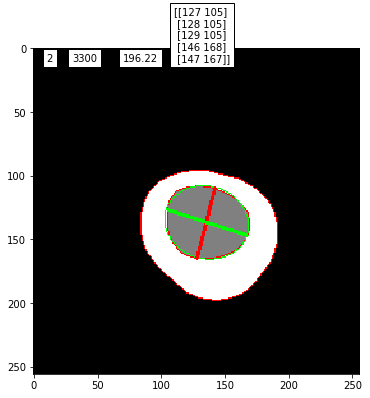

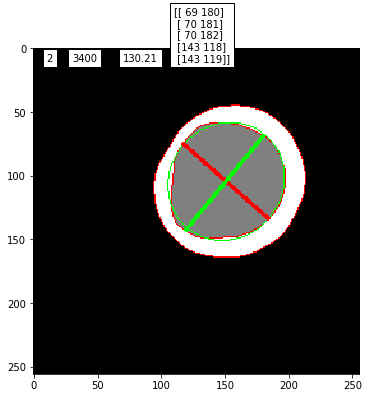

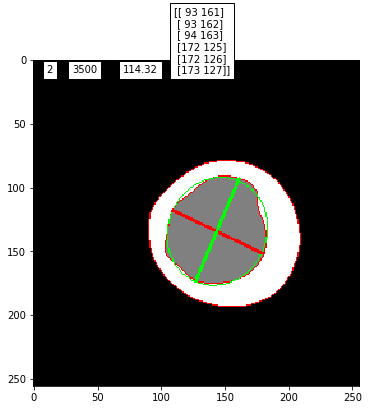

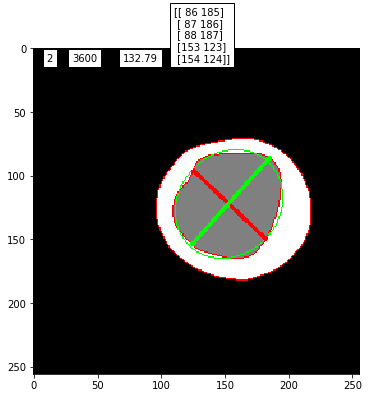

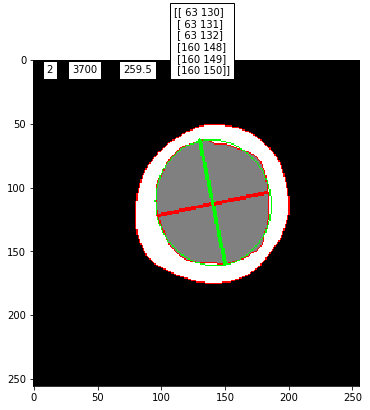

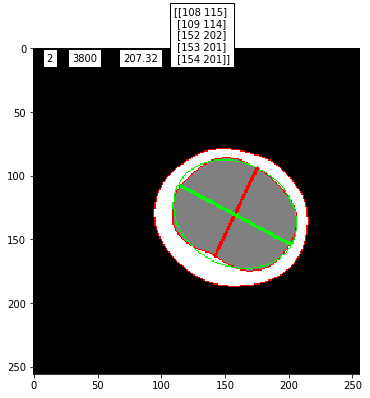

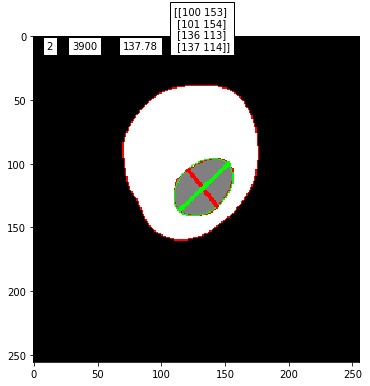

In [2]:
def lumen_diameter(i, show=True):
    frame = im[i]
    frame8 = cv2.convertScaleAbs(frame,alpha=(255.0/2.0))
    ret, thresh = cv2.threshold(frame8, 129, 255, 0)

    #rgb only for drawing contours
    framergb = cv2.cvtColor(frame8,cv2.COLOR_GRAY2RGB)
    _, contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
    # test contour has parent-child relationship
    if len(hierarchy[0]) == 2:
        im2 = framergb.copy()
        cv2.drawContours(im2, contours, -1, (255,0,0), 1)
        
        
        plaque_c = contours[0]
        lumen_c = contours[1]
        (x, y), (minaxis, maxaxis), angle = cv2.fitEllipse(lumen_c)
        ellipse = cv2.fitEllipse(lumen_c)
        cv2.ellipse(im2,ellipse,(0,255,0),1)
        cv2.circle(im2, (round(x),round(y)), 2, (0,255,0), -1)
        
        l = 200
        
        #short axis
        x1 = x + -l * math.cos(math.radians(angle))
        y1 = y + -l * math.sin(math.radians(angle))
        x2 = x + l * math.cos(math.radians(angle))
        y2 = y + l * math.sin(math.radians(angle))
        
        #intersection short axis
        lineimg = np.zeros((256,256), np.uint8)
        cv2.line(lineimg, (round(x1),round(y1)),(round(x2), round(y2)), (255,0,0),2)
        contourimg = np.zeros((256,256,3), np.uint8)
        cv2.drawContours(contourimg, lumen_c, -1, (255,255,255), 1)
        contourimg = cv2.cvtColor(contourimg, cv2.COLOR_BGR2GRAY)
        imgcombo = cv2.bitwise_and(lineimg,contourimg)
        intersect = np.argwhere(imgcombo == 255)
        x1 = intersect[0][1]
        y1 = intersect[0][0]
        x2 = intersect[-1][1]
        y2 = intersect[-1][0]
        #the x,y coordinates are backwards when the intersection is found
        
        
        cv2.line(im2, (round(x1),round(y1)),(round(x2), round(y2)), (255,0,0),2)
        #red line short
        
        #long axis
        angle = angle +90
        x1 = x + -l * math.cos(math.radians(angle))
        y1 = y + -l * math.sin(math.radians(angle))
        x2 = x + l * math.cos(math.radians(angle))
        y2 = y + l * math.sin(math.radians(angle))
        
        #intersection long axis
        lineimg = np.zeros((256,256), np.uint8)
        cv2.line(lineimg, (round(x1),round(y1)),(round(x2), round(y2)), (255,0,0),2)
        contourimg = np.zeros((256,256,3), np.uint8)
        cv2.drawContours(contourimg, lumen_c, -1, (255,255,255), 1)
        contourimg = cv2.cvtColor(contourimg, cv2.COLOR_BGR2GRAY)
        imgcombo = cv2.bitwise_and(lineimg,contourimg)
        intersect = np.argwhere(imgcombo == 255)
        x1 = intersect[0][1]
        y1 = intersect[0][0]
        x2 = intersect[-1][1]
        y2 = intersect[-1][0]
        
        cv2.line(im2, (round(x1),round(y1)),(round(x2), round(y2)), (0,255,0),2)
        #green line long
        
        plt.figure(figsize=[6,6])
        plt.text(10,10,len(hierarchy[0]), bbox={'facecolor':'white'})
        plt.text(30,10,i, bbox={'facecolor':'white'})
        plt.text(70,10,round(angle,2), bbox={'facecolor':'white'})
        plt.text(110,10,intersect, bbox={'facecolor':'white'})
        plt.imshow(im2)
        
        
        
        
        
    
    
for i in range(0,im.shape[0])[::100]:
    lumen_diameter(i)

# Plaque Thickness

/Users/paulnguyen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


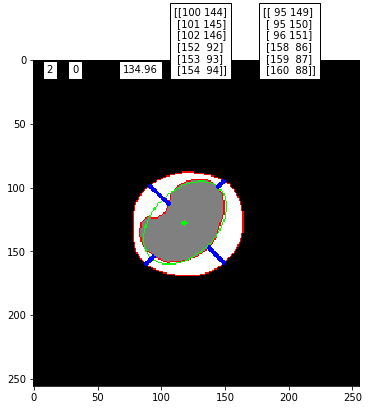

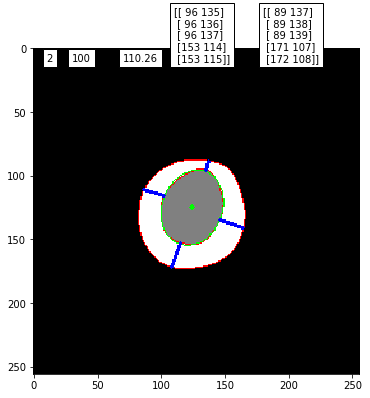

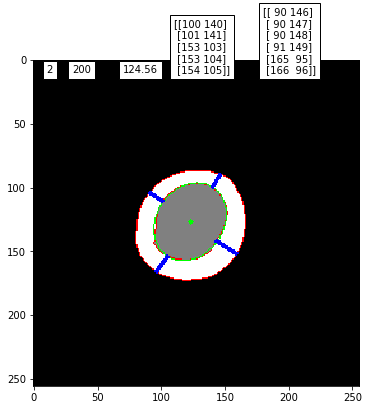

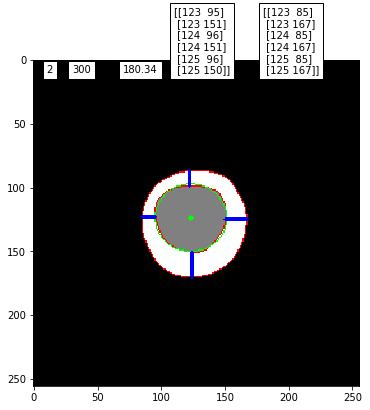

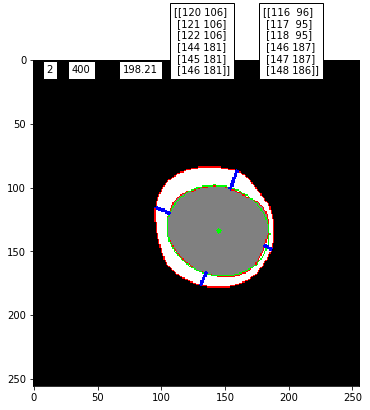

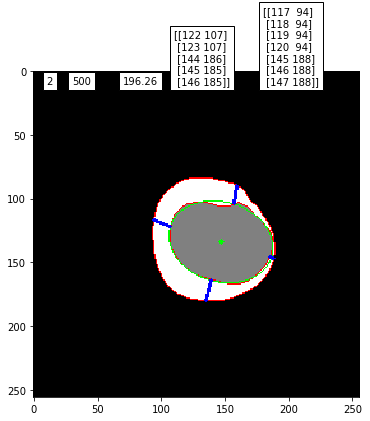

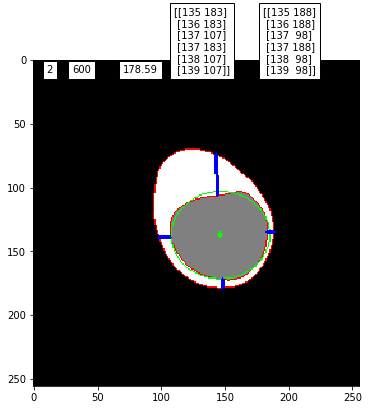

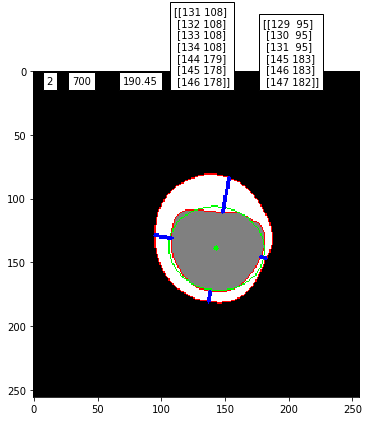

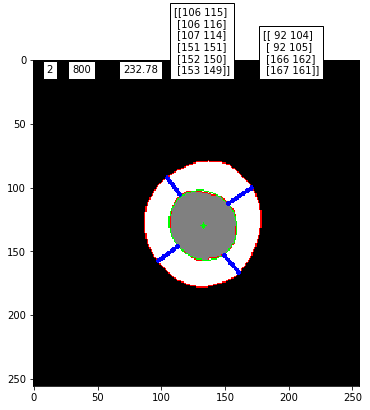

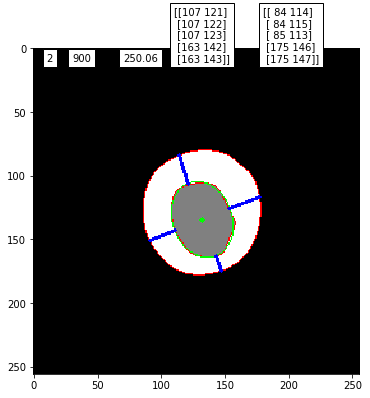

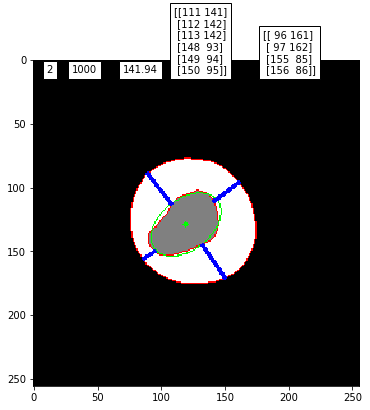

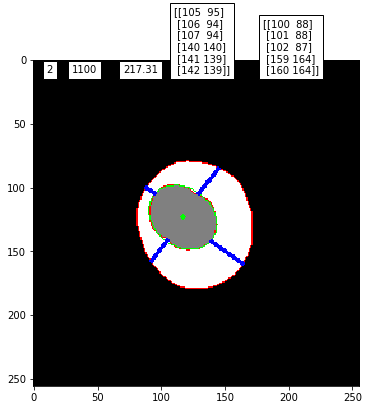

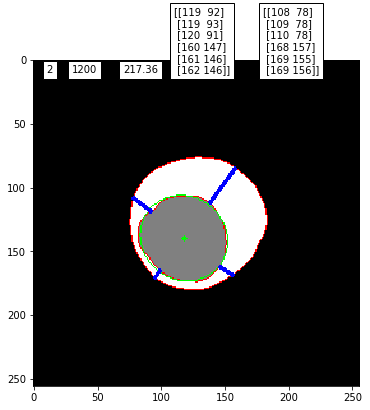

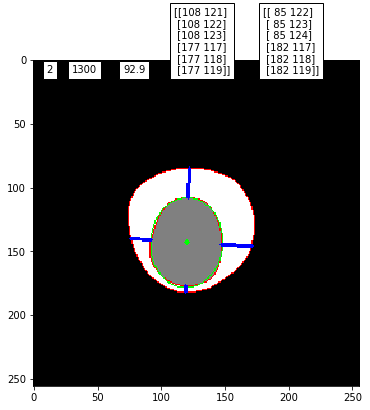

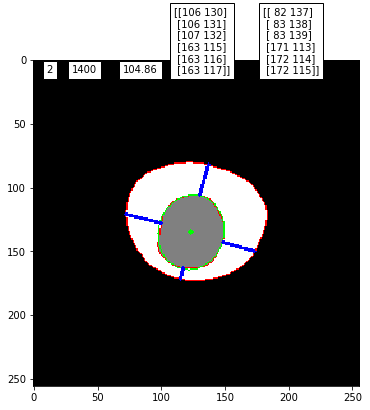

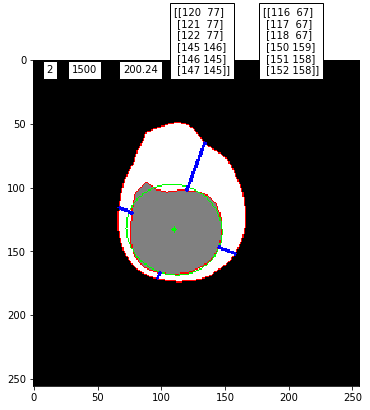

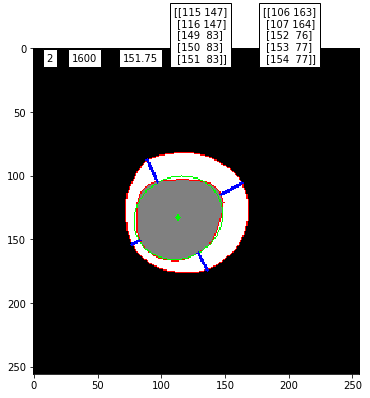

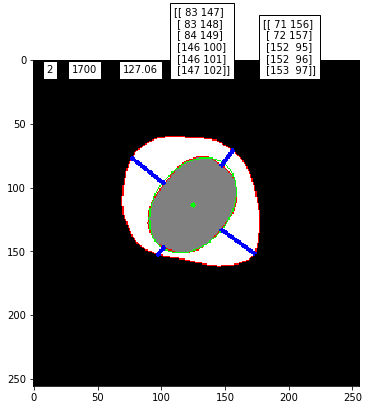

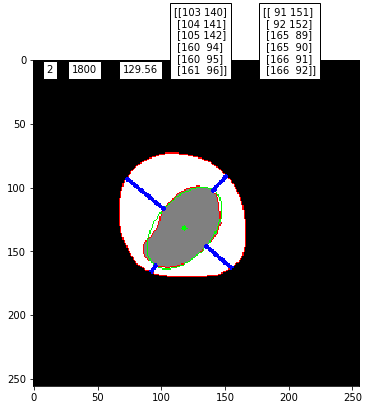

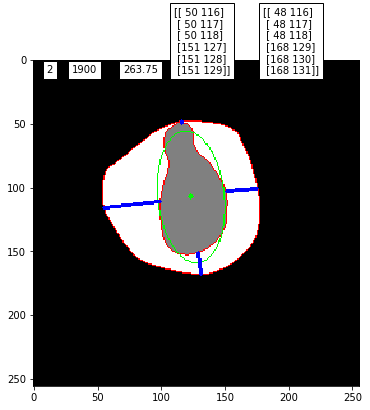

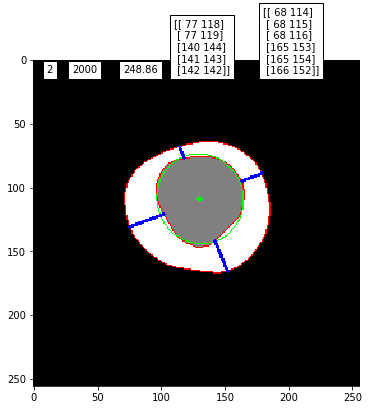

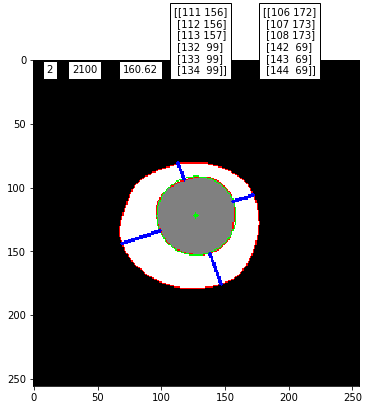

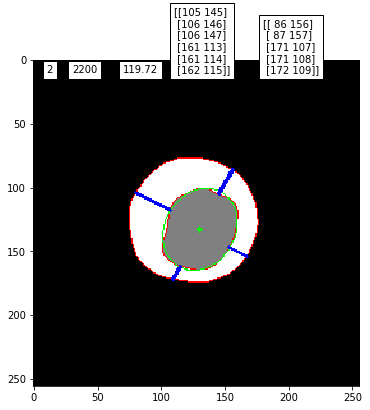

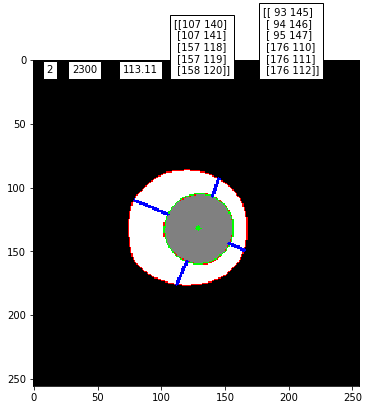

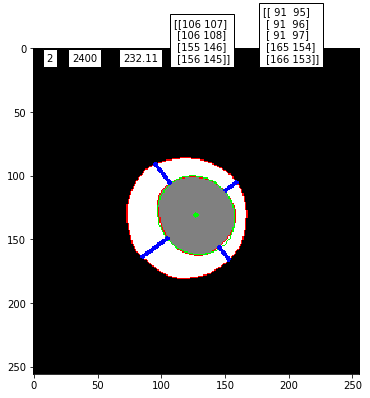

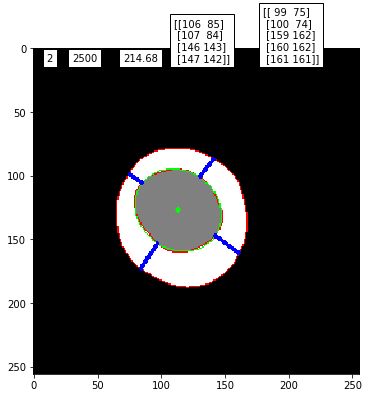

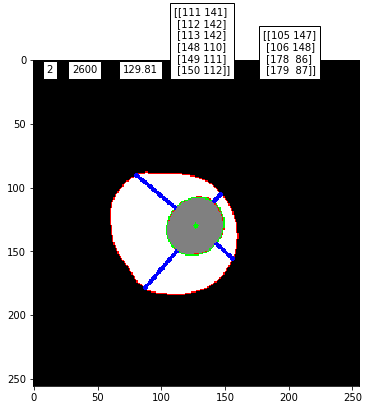

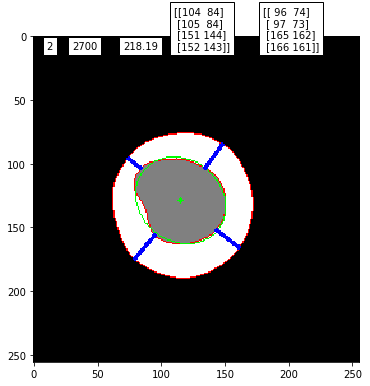

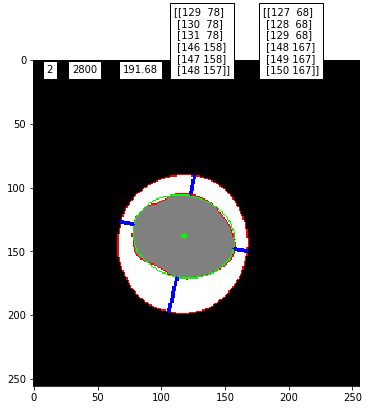

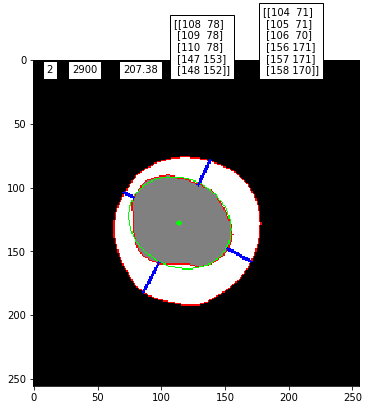

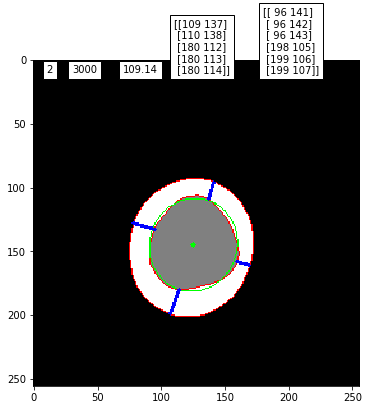

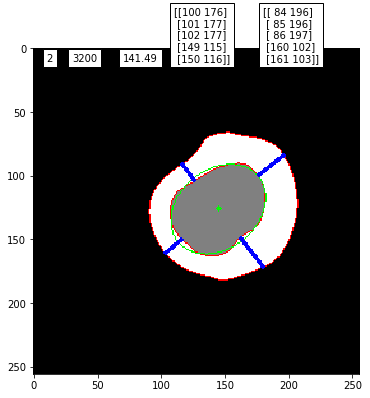

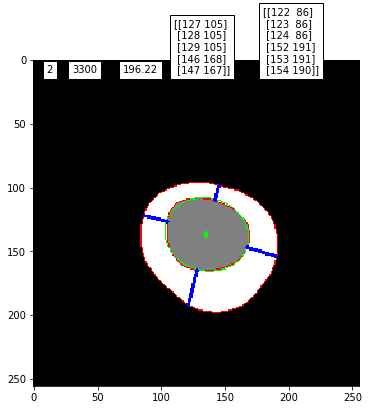

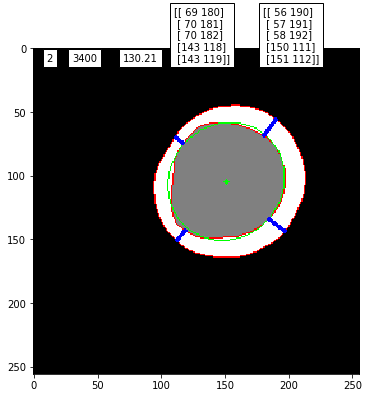

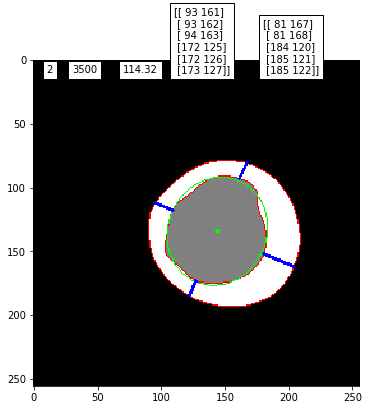

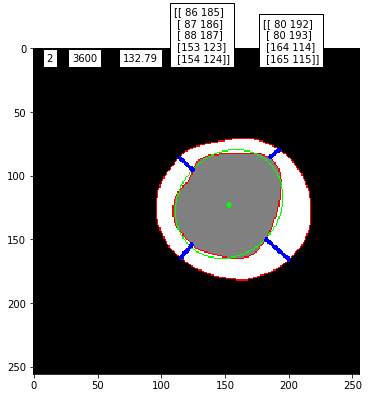

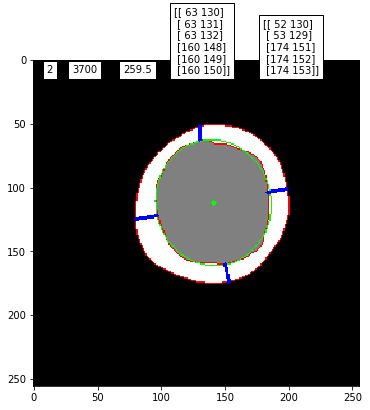

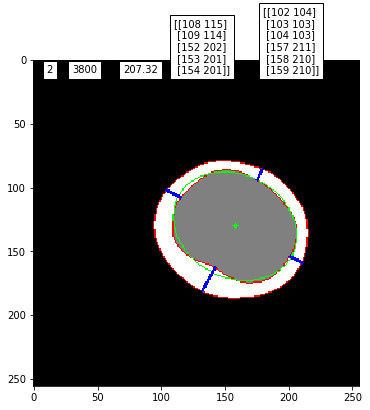

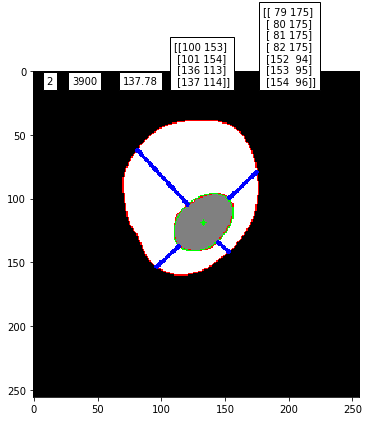

In [21]:
def plaque_thickness(i, show=True):
    frame = im[i]
    frame8 = cv2.convertScaleAbs(frame,alpha=(255.0/2.0))
    ret, thresh = cv2.threshold(frame8, 129, 255, 0)

    #rgb only for drawing contours
    framergb = cv2.cvtColor(frame8,cv2.COLOR_GRAY2RGB)
    _, contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
    # test contour has parent-child relationship
    if len(hierarchy[0]) == 2:
        im2 = framergb.copy()
        cv2.drawContours(im2, contours, -1, (255,0,0), 1)
        
        
        plaque_c = contours[0]
        lumen_c = contours[1]
        (x, y), (minaxis, maxaxis), angle = cv2.fitEllipse(lumen_c)
        ellipse = cv2.fitEllipse(lumen_c)
        cv2.ellipse(im2,ellipse,(0,255,0),1)
        cv2.circle(im2, (round(x),round(y)), 2, (0,255,0), -1)
        
        l = 200
        
        #short axis
        x1 = x + -l * math.cos(math.radians(angle))
        y1 = y + -l * math.sin(math.radians(angle))
        x2 = x + l * math.cos(math.radians(angle))
        y2 = y + l * math.sin(math.radians(angle))
        
        #intersection short axis - lumen
        lineimg = np.zeros((256,256), np.uint8)
        cv2.line(lineimg, (round(x1),round(y1)),(round(x2), round(y2)), (255,0,0),2)
        contourimg = np.zeros((256,256,3), np.uint8)
        cv2.drawContours(contourimg, lumen_c, -1, (255,255,255), 1)
        contourimg = cv2.cvtColor(contourimg, cv2.COLOR_BGR2GRAY)
        imgcombo = cv2.bitwise_and(lineimg,contourimg)
        intersect = np.argwhere(imgcombo == 255)
        
        #intersection short axis - plaque
        contourimg2 = np.zeros((256,256,3), np.uint8)
        cv2.drawContours(contourimg2, plaque_c, -1, (255,255,255), 1)
        contourimg2 = cv2.cvtColor(contourimg2, cv2.COLOR_BGR2GRAY)
        imgcombo2 = cv2.bitwise_and(lineimg,contourimg2)
        intersect2 = np.argwhere(imgcombo2 == 255)
        
        
        x1 = intersect[0][1]
        y1 = intersect[0][0]
        x2 = intersect2[0][1]
        y2 = intersect2[0][0]
        cv2.line(im2, (round(x1),round(y1)),(round(x2), round(y2)), (0,0,255),2)
        
        x1 = intersect[-1][1]
        y1 = intersect[-1][0]
        x2 = intersect2[-1][1]
        y2 = intersect2[-1][0]
        cv2.line(im2, (round(x1),round(y1)),(round(x2), round(y2)), (0,0,255),2)
        
        #long axis
        angle = angle + 90
        x1 = x + -l * math.cos(math.radians(angle))
        y1 = y + -l * math.sin(math.radians(angle))
        x2 = x + l * math.cos(math.radians(angle))
        y2 = y + l * math.sin(math.radians(angle))
        
        #intersection short axis - lumen
        lineimg = np.zeros((256,256), np.uint8)
        cv2.line(lineimg, (round(x1),round(y1)),(round(x2), round(y2)), (255,0,0),2)
        contourimg = np.zeros((256,256,3), np.uint8)
        cv2.drawContours(contourimg, lumen_c, -1, (255,255,255), 1)
        contourimg = cv2.cvtColor(contourimg, cv2.COLOR_BGR2GRAY)
        imgcombo = cv2.bitwise_and(lineimg,contourimg)
        intersect = np.argwhere(imgcombo == 255)
        
        #intersection short axis - plaque
        contourimg2 = np.zeros((256,256,3), np.uint8)
        cv2.drawContours(contourimg2, plaque_c, -1, (255,255,255), 1)
        contourimg2 = cv2.cvtColor(contourimg2, cv2.COLOR_BGR2GRAY)
        imgcombo2 = cv2.bitwise_and(lineimg,contourimg2)
        intersect2 = np.argwhere(imgcombo2 == 255)
        
        
        x1 = intersect[0][1]
        y1 = intersect[0][0]
        x2 = intersect2[0][1]
        y2 = intersect2[0][0]
        cv2.line(im2, (round(x1),round(y1)),(round(x2), round(y2)), (0,0,255),2)
        
        x1 = intersect[-1][1]
        y1 = intersect[-1][0]
        x2 = intersect2[-1][1]
        y2 = intersect2[-1][0]
        cv2.line(im2, (round(x1),round(y1)),(round(x2), round(y2)), (0,0,255),2)
        
        plt.figure(figsize=[6,6])
        plt.text(10,10,len(hierarchy[0]), bbox={'facecolor':'white'})
        plt.text(30,10,i, bbox={'facecolor':'white'})
        plt.text(70,10,round(angle,2), bbox={'facecolor':'white'})
        plt.text(110,10,intersect, bbox={'facecolor':'white'})
        plt.text(180,10,intersect2, bbox={'facecolor':'white'})
        plt.imshow(im2)
        
        
    
    
for i in range(0,im.shape[0])[::100]:
    plaque_thickness(i)

# Lumen Diameter Lengths

In [124]:
def lumen_diameter(i,imstack):
    diameters = []
    frame = imstack[i]
    frame8 = cv2.convertScaleAbs(frame,alpha=(255.0/2.0))
    ret, thresh = cv2.threshold(frame8, 129, 255, 0)

    #rgb only for drawing contours
    framergb = cv2.cvtColor(frame8,cv2.COLOR_GRAY2RGB)
    _, contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
    
    
    #plt.figure(figsize=[6,6])  #test
    #plt.imshow(frame8)  #test
    #print(i,len(np.unique(frame)))  #test
    
    
    # if frame is empty return none
    if len(np.unique(frame)) != 3:
        return None
    # if frame has two countours and lumen is child of the plaque contour
    elif len(hierarchy[0]) == 2 and hierarchy[0][1][-1] == 0:
        #print(hierarchy)  #test
        #print(hierarchy[0][1][-1])  #test
        im2 = framergb.copy()
        cv2.drawContours(im2, contours, -1, (255,0,0), 1)
        
        
        plaque_c = contours[0]
        lumen_c = contours[1]
        (x, y), (minaxis, maxaxis), angle = cv2.fitEllipse(lumen_c)
        
        l = 200
        
        #short axis
        x1 = x + -l * math.cos(math.radians(angle))
        y1 = y + -l * math.sin(math.radians(angle))
        x2 = x + l * math.cos(math.radians(angle))
        y2 = y + l * math.sin(math.radians(angle))
        
        #intersection short axis
        lineimg = np.zeros((256,256), np.uint8)
        cv2.line(lineimg, (round(x1),round(y1)),(round(x2), round(y2)), (255,0,0),2)
        contourimg = np.zeros((256,256,3), np.uint8)
        cv2.drawContours(contourimg, lumen_c, -1, (255,255,255), 1)
        contourimg = cv2.cvtColor(contourimg, cv2.COLOR_BGR2GRAY)
        imgcombo = cv2.bitwise_and(lineimg,contourimg)
        intersect = np.argwhere(imgcombo == 255)
        x1 = intersect[0][1]
        y1 = intersect[0][0]
        x2 = intersect[-1][1]
        y2 = intersect[-1][0]
        
        distance = sqrt((x2 - x1)**2 + (y2 - y1)**2 )
        diameters.append(distance)
        
        #long axis
        angle = angle +90
        x1 = x + -l * math.cos(math.radians(angle))
        y1 = y + -l * math.sin(math.radians(angle))
        x2 = x + l * math.cos(math.radians(angle))
        y2 = y + l * math.sin(math.radians(angle))
        
        #intersection long axis
        lineimg = np.zeros((256,256), np.uint8)
        cv2.line(lineimg, (round(x1),round(y1)),(round(x2), round(y2)), (255,0,0),2)
        contourimg = np.zeros((256,256,3), np.uint8)
        cv2.drawContours(contourimg, lumen_c, -1, (255,255,255), 1)
        contourimg = cv2.cvtColor(contourimg, cv2.COLOR_BGR2GRAY)
        imgcombo = cv2.bitwise_and(lineimg,contourimg)
        intersect = np.argwhere(imgcombo == 255)
        x1 = intersect[0][1]
        y1 = intersect[0][0]
        x2 = intersect[-1][1]
        y2 = intersect[-1][0]
        
        distance = sqrt((x2 - x1)**2 + (y2 - y1)**2 )
        diameters.append(distance)
        return diameters
    return None

def im2arr(x):
    return sitk.GetArrayFromImage(sitk.ReadImage(x))

def ecc_lumen(pid,region,mhadir):
    files = sorted(glob.glob(mhadir+"/*.mha"))
    indices = [i for i, s in enumerate(files) if pid in s][0]
    imstack = im2arr(files[indices])
    stack_diameter = [lumen_diameter(frame,imstack) for frame in region]
    stack_diameter = list(filter(None.__ne__, stack_diameter))
    d_min = [item[0] for item in stack_diameter]
    d_max = [item[1] for item in stack_diameter]
    #return d_min, d_max
    return np.mean(np.sqrt(np.power(d_max,2) - np.power(d_min,2))/d_max)
    #return stack_diameter

#test with region between 0 - 10
mhadir= "data"
region = list(range(0, 10))
test = ecc_lumen('F0005',region,'data')
print(test)

#stack_diameter = [lumen_diameter(frame,im) for frame in region]
#print(stack_diameter)

0.784551168252


# Plaque Thickness Lengths

In [143]:
def plaque_thickness(i, imstack):
    thickness = []
    frame = imstack[i]
    frame8 = cv2.convertScaleAbs(frame,alpha=(255.0/2.0))
    ret, thresh = cv2.threshold(frame8, 129, 255, 0)

    #rgb only for drawing contours
    framergb = cv2.cvtColor(frame8,cv2.COLOR_GRAY2RGB)
    _, contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_NONE)
    # if frame is empty return none
    if len(np.unique(frame)) != 3:
        return None
    # if frame has two countours and lumen is child of the plaque contour
    elif len(hierarchy[0]) == 2 and hierarchy[0][1][-1] == 0:
        im2 = framergb.copy()
        cv2.drawContours(im2, contours, -1, (255,0,0), 1)    
        
        plaque_c = contours[0]
        lumen_c = contours[1]
        (x, y), (minaxis, maxaxis), angle = cv2.fitEllipse(lumen_c)
        
        l = 200
        
        #short axis
        x1 = x + -l * math.cos(math.radians(angle))
        y1 = y + -l * math.sin(math.radians(angle))
        x2 = x + l * math.cos(math.radians(angle))
        y2 = y + l * math.sin(math.radians(angle))
        
        #intersection short axis - lumen
        lineimg = np.zeros((256,256), np.uint8)
        cv2.line(lineimg, (round(x1),round(y1)),(round(x2), round(y2)), (255,0,0),2)
        contourimg = np.zeros((256,256,3), np.uint8)
        cv2.drawContours(contourimg, lumen_c, -1, (255,255,255), 1)
        contourimg = cv2.cvtColor(contourimg, cv2.COLOR_BGR2GRAY)
        imgcombo = cv2.bitwise_and(lineimg,contourimg)
        intersect = np.argwhere(imgcombo == 255)
        
        #intersection short axis - plaque
        contourimg2 = np.zeros((256,256,3), np.uint8)
        cv2.drawContours(contourimg2, plaque_c, -1, (255,255,255), 1)
        contourimg2 = cv2.cvtColor(contourimg2, cv2.COLOR_BGR2GRAY)
        imgcombo2 = cv2.bitwise_and(lineimg,contourimg2)
        intersect2 = np.argwhere(imgcombo2 == 255)
        
        x1 = intersect[0][1]
        y1 = intersect[0][0]
        x2 = intersect2[0][1]
        y2 = intersect2[0][0]
        distance = sqrt((x2 - x1)**2 + (y2 - y1)**2 )
        thickness.append(distance)
        
        x1 = intersect[-1][1]
        y1 = intersect[-1][0]
        x2 = intersect2[-1][1]
        y2 = intersect2[-1][0]
        distance = sqrt((x2 - x1)**2 + (y2 - y1)**2 )
        thickness.append(distance)
        
        #long axis
        angle = angle + 90
        x1 = x + -l * math.cos(math.radians(angle))
        y1 = y + -l * math.sin(math.radians(angle))
        x2 = x + l * math.cos(math.radians(angle))
        y2 = y + l * math.sin(math.radians(angle))
        
        #intersection short axis - lumen
        lineimg = np.zeros((256,256), np.uint8)
        cv2.line(lineimg, (round(x1),round(y1)),(round(x2), round(y2)), (255,0,0),2)
        contourimg = np.zeros((256,256,3), np.uint8)
        cv2.drawContours(contourimg, lumen_c, -1, (255,255,255), 1)
        contourimg = cv2.cvtColor(contourimg, cv2.COLOR_BGR2GRAY)
        imgcombo = cv2.bitwise_and(lineimg,contourimg)
        intersect = np.argwhere(imgcombo == 255)
        
        #intersection short axis - plaque
        contourimg2 = np.zeros((256,256,3), np.uint8)
        cv2.drawContours(contourimg2, plaque_c, -1, (255,255,255), 1)
        contourimg2 = cv2.cvtColor(contourimg2, cv2.COLOR_BGR2GRAY)
        imgcombo2 = cv2.bitwise_and(lineimg,contourimg2)
        intersect2 = np.argwhere(imgcombo2 == 255)
        
        x1 = intersect[0][1]
        y1 = intersect[0][0]
        x2 = intersect2[0][1]
        y2 = intersect2[0][0]
        distance = sqrt((x2 - x1)**2 + (y2 - y1)**2 )
        thickness.append(distance)
        
        x1 = intersect[-1][1]
        y1 = intersect[-1][0]
        x2 = intersect2[-1][1]
        y2 = intersect2[-1][0]
        distance = sqrt((x2 - x1)**2 + (y2 - y1)**2 )
        thickness.append(distance)
        
        return min(thickness),max(thickness)
    return None
    

def im2arr(x):
    return sitk.GetArrayFromImage(sitk.ReadImage(x))

def ecc_lumen(pid,region,mhadir):
    files = sorted(glob.glob(mhadir+"/*.mha"))
    indices = [i for i, s in enumerate(files) if pid in s][0]
    imstack = im2arr(files[indices])
    stack_thickness = [plaque_thickness(frame,imstack) for frame in region]
    stack_thickness = list(filter(None.__ne__, stack_thickness))
    p_min = [item[0] for item in stack_thickness]
    p_max = [item[1] for item in stack_thickness]
    return np.mean(np.sqrt(np.power(p_max,2) - np.power(p_min,2))/p_max)

#test with region between 0 - 10
mhadir= "data"
region = list(range(0, 10))
test = ecc_lumen('F0005',region,'data')
print(test)

#stack_diameter = [lumen_diameter(frame,im) for frame in region]
#print(stack_diameter) 
    
#for i in range(0,im.shape[0]):
#    print(plaque_thickness(i))
    
    

0.957934739485
